# [Pennylane](https://pennylane.ai/)

Documentation of the latest stable release is [here](https://docs.pennylane.ai/en/stable/).

Different machine learning demos can be found [here](https://pennylane.ai/qml/demos_qml).

## Example: Finding function describing the data

Starting with the necessary imports

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

Let's create our function to generate our data.

In [2]:
def sample_function(data):
    return np.sin(data)

And generate our training and testing datasets:

In [3]:
#Training data

x_train = np.linspace(0,2*np.pi, 10)
# We tell the optimizer that this is an input datapoint, and not a parameter to optimize over.
x_train.requires_grad = False
y_train = sample_function(x_train)

#Testing data
x_test = np.linspace(0, 2*np.pi, 4)
y_test = sample_function(x_test)

Now we create our quantum device using only one qubit (wires=1)

In [4]:
dev = qml.device('default.qubit', wires=1)

Next we create our quantum circuit

In [5]:
@qml.qnode(dev)
def quantum_circuit(datapoint, params):
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)
    # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)
    # We return the expected value of a measurement along the Z axis
    return qml.expval(qml.PauliZ(wires=0))

Now the postprocessing function:

In [6]:
def loss_func(predictions, train_result):
    # This is a postprocessing step. Here we use a least squares metric
    # based on the predictions of the quantum circuit and the outputs
    # of the training data points.
    total_losses = 0
    for i in range(len(train_result)):
        output = train_result[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

And finally the whole cost function

In [7]:
def cost_fn(params):
    train_data = x_train
    train_result = y_train
    # We get the predictions of the quantum circuit for a specific
    # set of parameters along the entire input dataset
    predictions = [quantum_circuit(t, params)  for t in train_data]
    # We calculate the cost including any classical postprocessing
    cost = loss_func(predictions,train_result=train_result)
    return cost


Now we can construct our model

In [8]:

# We define the optimizer
opt = qml.AdamOptimizer(stepsize=0.3)

#  We make an initial guess for the parameters
parameters = np.array([0.1,0.1,0.1], requires_grad=True)
# We iterate over a number of defined steps
step_num = 100
for i in range (step_num):
    # Over each step the parameters change to give a better cost
    parameters, prev_cost = opt.step_and_cost(cost_fn, parameters)
    if i%10 == 0:
         # We print the result after every 10 steps
        print(f'Step = {i} Cost = {cost_fn(parameters)}')


# Printing the converged circuit
print(qml.draw(quantum_circuit)(datapoint=x_train[0],params=parameters))



Step = 0 Cost = 8.496589466538875
Step = 10 Cost = 1.4908033791072886
Step = 20 Cost = 0.4525719535180654
Step = 30 Cost = 0.18308328227820206
Step = 40 Cost = 0.0570927170013767
Step = 50 Cost = 0.011422260292770443
Step = 60 Cost = 0.00024960217241919104
Step = 70 Cost = 0.0011507798139345116
Step = 80 Cost = 0.0012371688260067657
Step = 90 Cost = 6.289907849216597e-05
0: ──RX(0.00)──Rot(-1.63,1.57,0.10)─┤  <Z>


We show the results

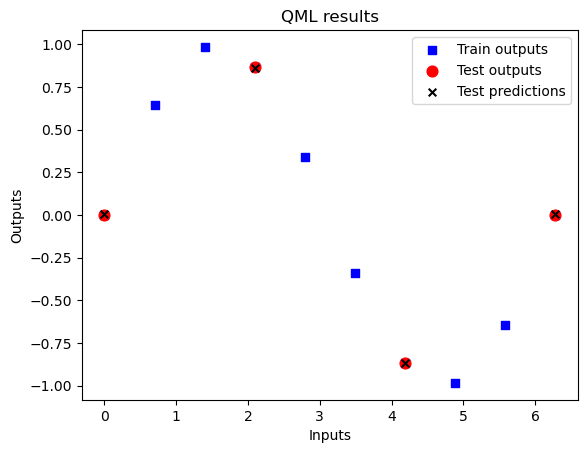

In [9]:
# Step 6 - Test and graph your results!
test_predictions = []
for x in x_test:
    prediction = quantum_circuit(x,parameters)
    test_predictions.append(prediction)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x_train, y_train, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(x_test, y_test, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(x_test,test_predictions, s=30, c='k', marker="x", label='Test predictions')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')